In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread, imshow
from skimage.morphology import binary_dilation, binary_erosion, disk
from skimage.filters import gaussian
import pickle
import os, re
from scipy.stats import ttest_ind, entropy

In [2]:
fnames = os.listdir("./images/")
pattern = re.compile(r' (\d+_(?:WT|KO))')
snames = [re.search(pattern, fname).group(1) for fname in fnames]
images = [imread("./images/" + fname) for fname in fnames]
# Channels are 0 for regular, 1 for sted, 2 for DAPI

In [3]:
nchan = np.array([img.shape[2] for img in images])
remove = np.where(nchan != 3)[0].item()
_=fnames.pop(remove)
_=snames.pop(remove)
_=images.pop(remove)

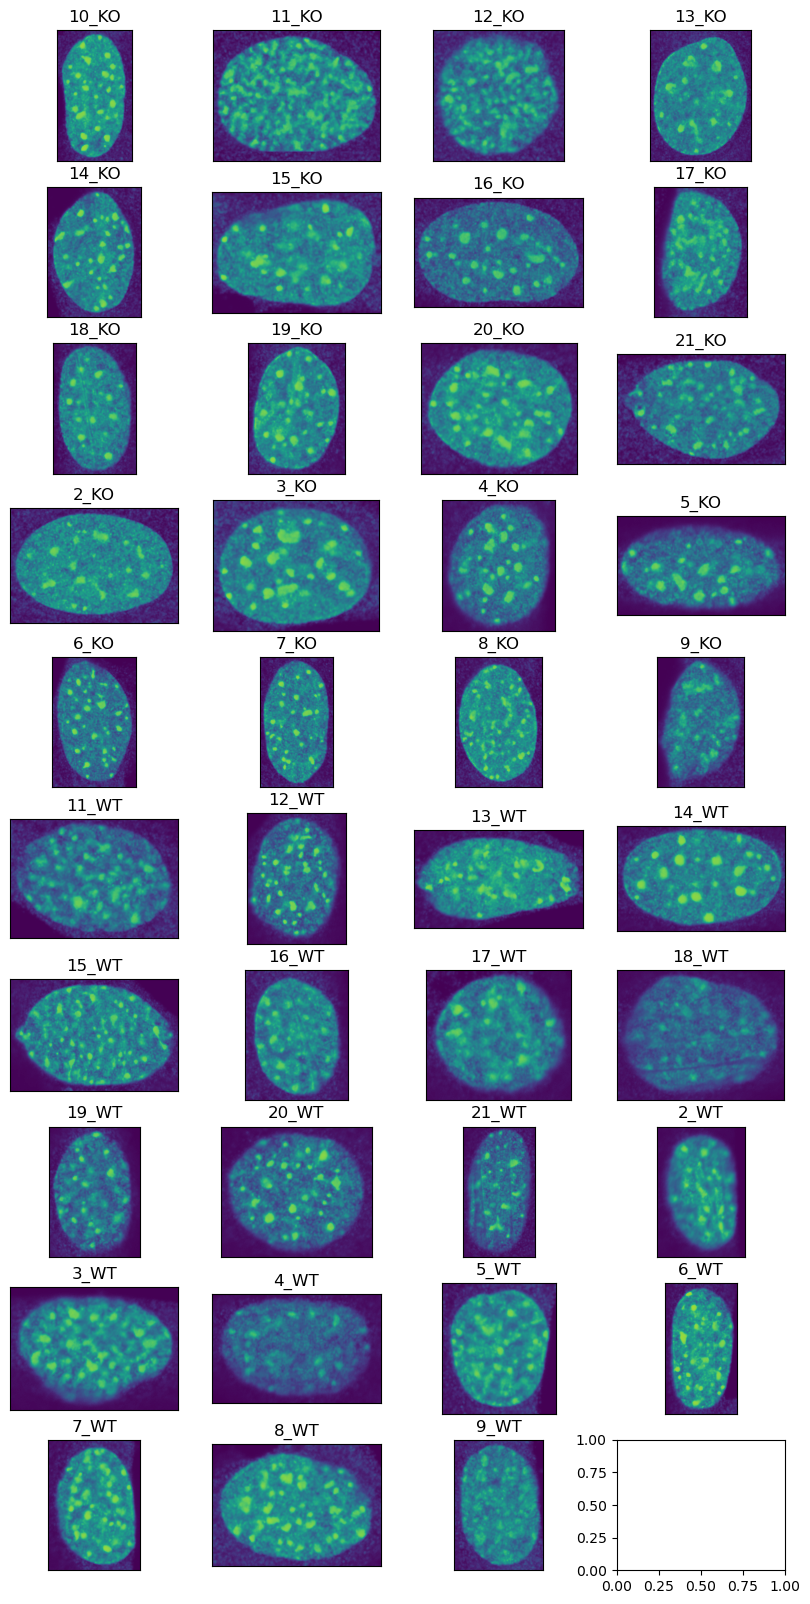

In [4]:
fig, axs = plt.subplots(10, 4, figsize=(10, 20))
axs = axs.ravel()
for i, img in enumerate(images):
    axs[i].imshow(img[:,:,0], vmax=200) # 600 for sted, 200 ish for regular
    axs[i].set_title(snames[i])
    axs[i].set_xticks([])
    axs[i].set_yticks([])

## Envelope Segmentation

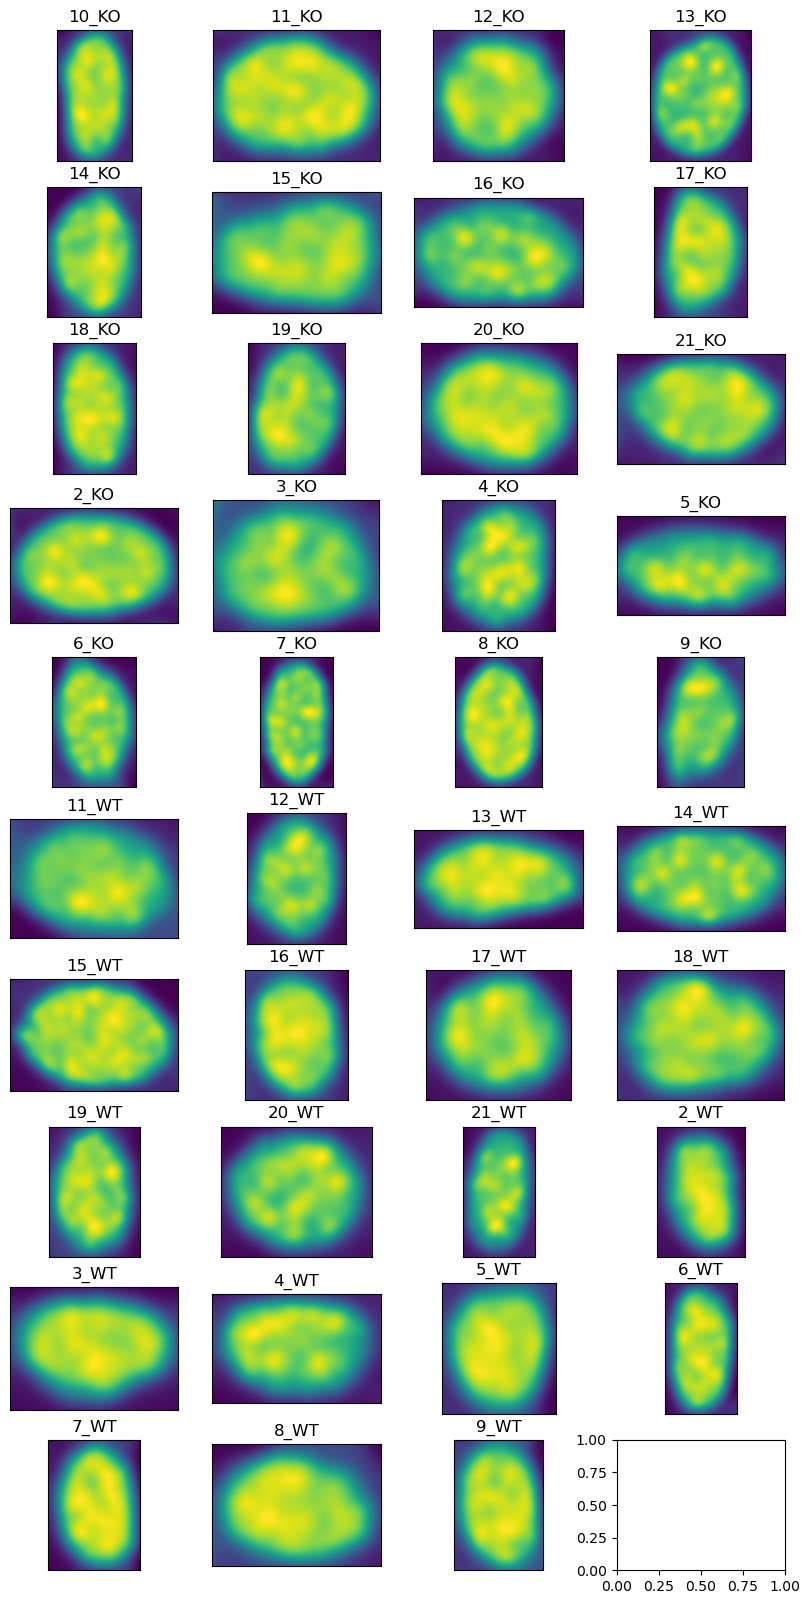

In [5]:
blurred = [gaussian(img[:,:,0], 50) for img in images]
fig, axs = plt.subplots(10, 4, figsize=(10, 20))
axs = axs.ravel()
for i, img in enumerate(blurred):
    axs[i].imshow(img)
    axs[i].set_title(snames[i])
    axs[i].set_xticks([])
    axs[i].set_yticks([])

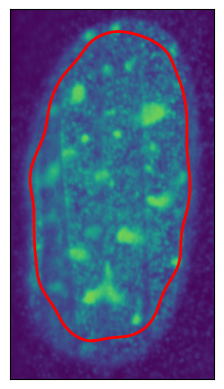

In [6]:
from skimage.measure import find_contours
# Find contours at a constant value of 0.8
test_img_i = 30
contours = find_contours(blurred[test_img_i])

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(images[test_img_i][:,:,0], vmax=200)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color="red")

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

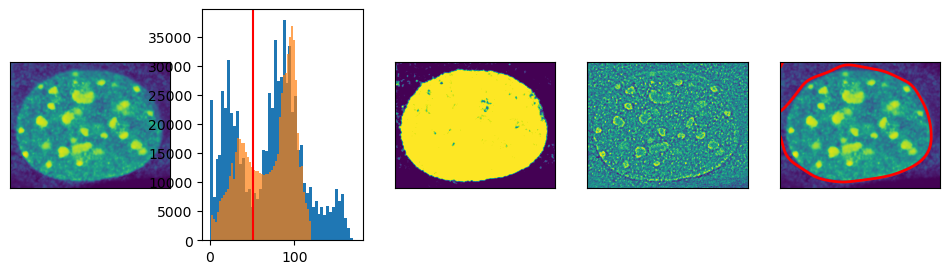

In [7]:
# Even using an edge method, some dim nuclei are detected badly. Need an adaptive method.
# Lets loot at the histogram.
from skimage.filters import threshold_otsu, threshold_isodata, threshold_li, threshold_mean, threshold_minimum, threshold_triangle, threshold_yen
from skimage.filters import threshold_local

test_image_ind = 13
test_image = images[test_image_ind][:,:,0]

# Li good, minimum good

th = threshold_minimum(test_image)
tresholded = test_image > th
tresholded_local = threshold_local(test_image, block_size=21)

contours = find_contours(blurred[test_image_ind], level=th)


fig, axs = plt.subplots(1,5, figsize=(12,3))

axs[0].imshow(test_image)
axs[0].set_xticks([])
axs[0].set_yticks([])

_=axs[1].hist(test_image.flatten(), bins=50)
_=axs[1].hist(blurred[test_image_ind].flatten(), bins=50, alpha = 0.7) # The separation is less clear when blurred. Select th on unblurred
axs[1].axvline(th, color="red")
axs[2].imshow(tresholded)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[3].imshow(test_image > tresholded_local)
axs[3].set_xticks([])
axs[3].set_yticks([])
axs[4].imshow(test_image)
axs[4].set_xticks([])
axs[4].set_yticks([])
for contour in contours:
    axs[4].plot(contour[:, 1], contour[:, 0], linewidth=2, color="red")

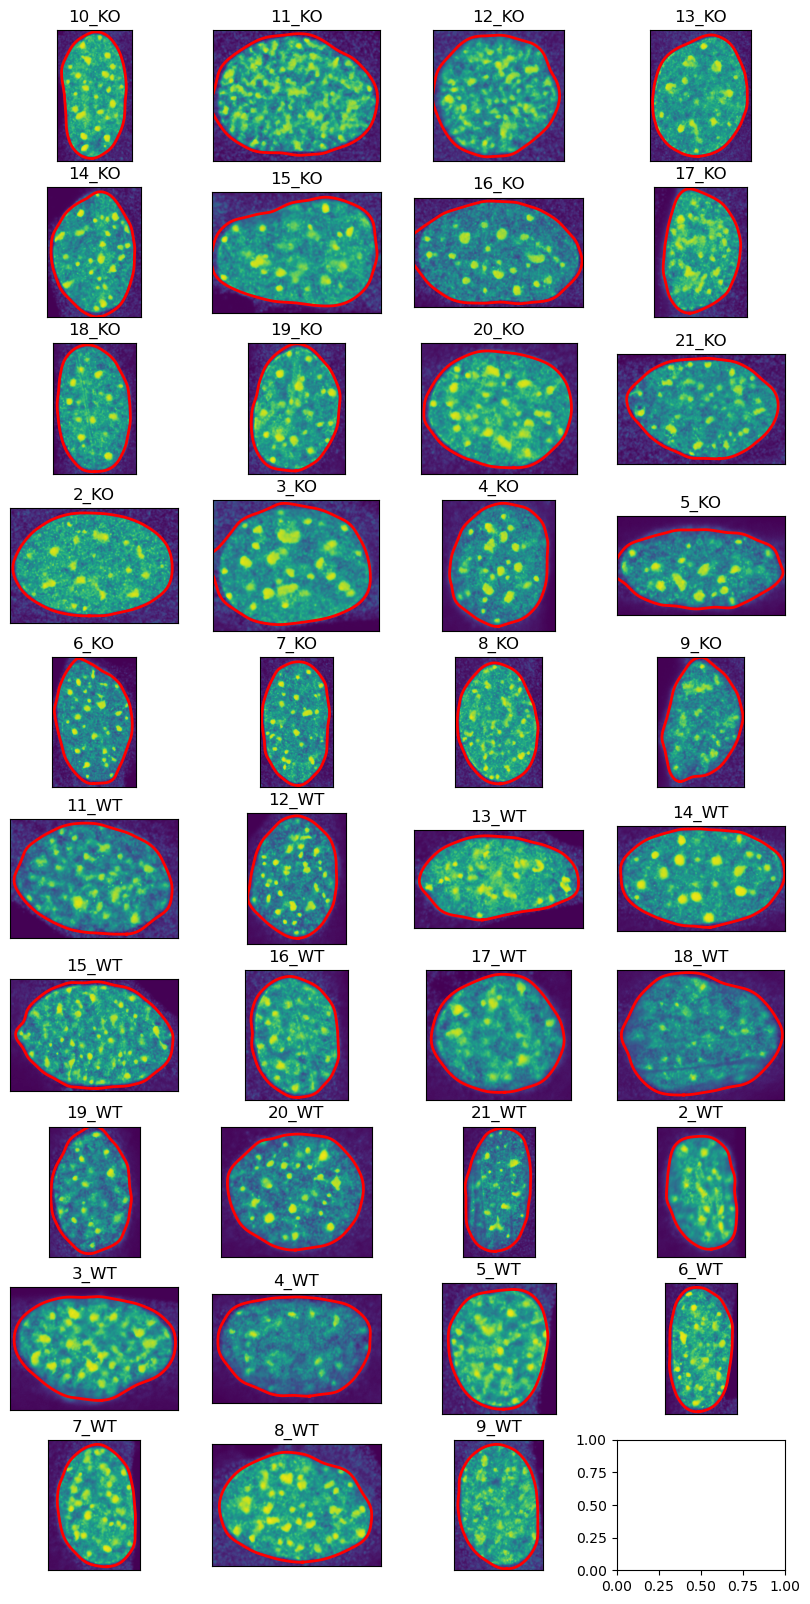

In [8]:
from skimage.draw import polygon
thresholds = []
contours = []
# nuclei = []
fig, axs = plt.subplots(10, 4, figsize=(10, 20))
axs = axs.ravel()
for i, img in enumerate(blurred):
    th = threshold_minimum(images[i][:,:,0])
    thresholds.append(th)
    res = find_contours(img, th)
    longest_contour = np.argmax(np.array([len(c) for c in res]))
    contours.append(res[longest_contour])
    # mask = np.zeros(img.shape, dtype=bool)
    
    axs[i].imshow(images[i][:,:,0])
    axs[i].set_title(snames[i])
    axs[i].plot(contours[i][:, 1], contours[i][:, 0], linewidth=2, color="red")
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [9]:
from skimage.measure import grid_points_in_poly
masks = []
for i, img in enumerate(blurred):
    masks.append(grid_points_in_poly(img.shape, contours[i]))

In [10]:
nuclei = []

for i, img in enumerate(masks):
    tmp = img.copy()
    tmp[0, :] = False
    tmp[:, 0] = False
    tmp[img.shape[0]-1, :] = False
    tmp[:, img.shape[1]-1] = False
    nuclei.append(tmp)

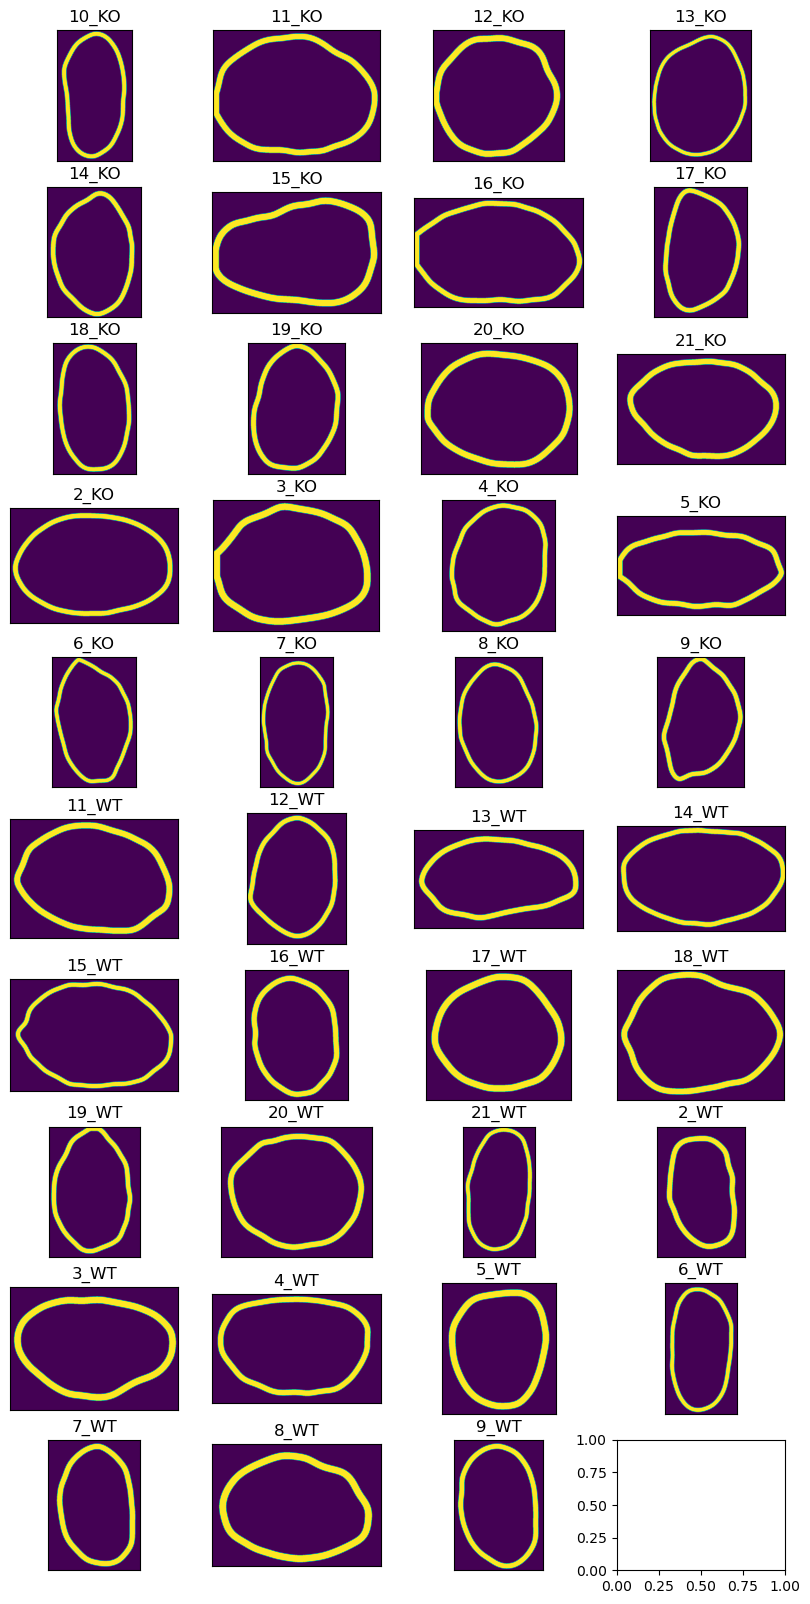

In [11]:
inner = [binary_erosion(img, disk(40)) for img in nuclei] # First result was with 30
outer = [np.logical_and(nuclei[i], ~inner[i]) for i in range(len(nuclei))]
fig, axs = plt.subplots(10, 4, figsize=(10, 20))
axs = axs.ravel()
for i, img in enumerate(outer):
    axs[i].imshow(img)
    axs[i].set_title(snames[i])
    axs[i].set_xticks([])
    axs[i].set_yticks([])

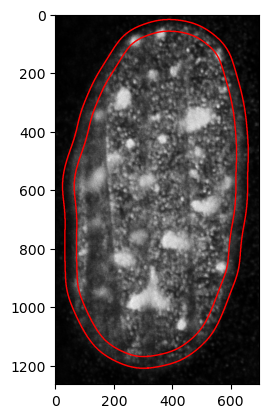

In [12]:
from skimage import measure

i = 30
fig, ax = plt.subplots()
ax.imshow(images[i][:,:,1], cmap='gray')

# Draw lamina contours in red
contours = measure.find_contours(outer[i], 0.5)
for c in contours:
    ax.plot(c[:, 1], c[:, 0], color='red', linewidth=1)

plt.show()

## Lamina / Center signal

In [13]:
mean_all = []
mean_inner = []
mean_outer = []
mean_not_inner = [] # Envelope but also outside of cell
for i in range(len(images)):
    h3k9me3 = images[i][:,:,1]
    mask_inner = inner[i]
    mask_outer = outer[i]
    mean_all.append(h3k9me3.mean())
    mean_inner.append(h3k9me3[mask_inner].mean())
    mean_outer.append(h3k9me3[mask_outer].mean())
    mean_not_inner.append(h3k9me3[~mask_inner].mean())
mean_all = np.array(mean_all)
mean_inner = np.array(mean_inner)
mean_outer = np.array(mean_outer)
mean_not_inner = np.array(mean_not_inner)

In [14]:
results = pd.DataFrame({
    "sname": snames,
    "mean_all": mean_all,
    "mean_inner": mean_inner,
    "mean_outer": mean_outer,
    "mean_not_inner": mean_not_inner})
results["outer_over_inner"] = results["mean_outer"] / results["mean_inner"]
results["not_inner_over_inner"] = results["mean_not_inner"] / results["mean_inner"]
results["genotype"] = "WT"
results.loc[results["sname"].str.contains("KO"), "genotype"] = "KO"

<Axes: xlabel='genotype', ylabel='not_inner_over_inner'>

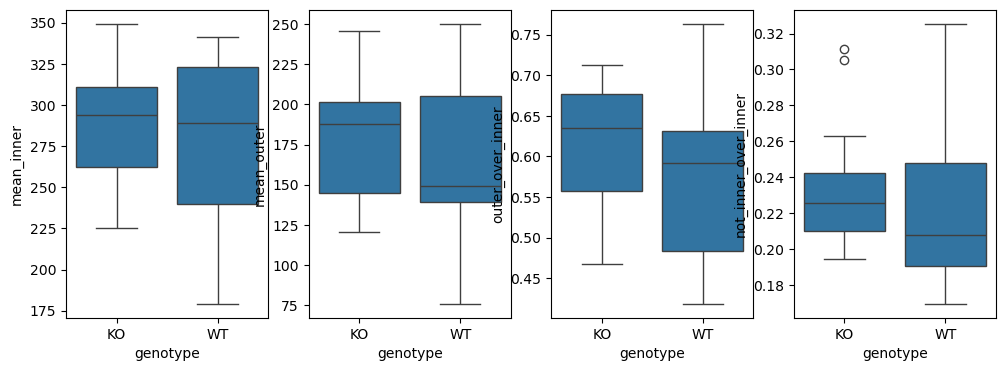

In [15]:
fix, axs = plt.subplots(1,4, figsize=(12, 4))
sns.boxplot(data=results, x="genotype", y="mean_inner", ax=axs[0])
sns.boxplot(data=results, x="genotype", y="mean_outer", ax=axs[1])
sns.boxplot(data=results, x="genotype", y="outer_over_inner", ax=axs[2])
sns.boxplot(data=results, x="genotype", y="not_inner_over_inner", ax=axs[3])

In [16]:

_,p=ttest_ind(results.loc[results["genotype"] == "WT", "outer_over_inner"], results.loc[results["genotype"] == "KO", "outer_over_inner"], nan_policy="omit")
print(p)
_,p=ttest_ind(results.loc[results["genotype"] == "WT", "not_inner_over_inner"], results.loc[results["genotype"] == "KO", "not_inner_over_inner"], nan_policy="omit")
print(p)

0.17719910089213806
0.33741925805744843


## Entropy

In [17]:
values_wt = []
values_ko = []
nucleus_entropy = []
for i in range(len(images)):
    h3k9me3 = images[i][:,:,1]
    mask_nuclear = nuclei[i]
    flat_values = h3k9me3[mask_nuclear].flatten()
    nucleus_entropy.append(entropy(flat_values))
    if results["genotype"][i] == "WT":
        values_wt.append(flat_values)
    else:
        values_ko.append(flat_values)
values_wt = np.concatenate(values_wt)
values_ko = np.concatenate(values_ko)

pval = 0.044209062553158394


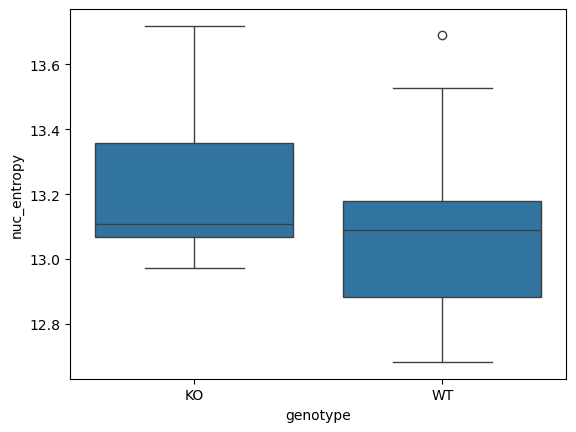

In [18]:
results["nuc_entropy"] = nucleus_entropy
sns.boxplot(data=results, x="genotype", y="nuc_entropy")
_,p=ttest_ind(results.loc[results["genotype"] == "WT", "nuc_entropy"], results.loc[results["genotype"] == "KO", "nuc_entropy"])
print("pval = " + str(p))

In [20]:
results.to_csv("./results_sted.csv")